# Keypoints 
#### This notebook showcases the functions for keypoint **interpolation**. For finding keypoint locations (Difference of Gaussian extrema), see notebook 1.

## Imports

In [1]:
# Handles relative import
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

import cv2
import numpy as np
import matplotlib.pyplot as plt

import const
import octaves as octaves_lib
import keypoints as keypoints_lib

## Find Candidate Keypoint (extrema) 

In [2]:
img = cv2.imread('../images/box_in_scene.png', flags=cv2.IMREAD_GRAYSCALE)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img = img[0:300, 100:400]
gauss_octaves = octaves_lib.build_gaussian_octaves(img)
dog_octave = octaves_lib.build_dog_octave(gauss_octaves[0])
extrema = octaves_lib.find_dog_extrema(dog_octave)
extremum = extrema.T[9]
s, y, x = extremum
derivs, second_derivs = octaves_lib.derivatives(dog_octave)
print(f'An extremum coordinate \n\nscale: {s} \ny: {y} \nx: {x}')

An extremum coordinate 

scale: 1 
y: 59 
x: 156


## Extremum Neighborhood

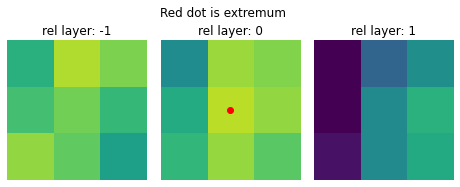

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3), gridspec_kw={'wspace':0.1, 'hspace':0}, squeeze=True)

s, y, x = extremum
patch = dog_octave[s - 1: s + 2, 
                   y - 1: y + 2, 
                   x - 1: x + 2]

for i in range(3):
    axs[i].axis('off')
    axs[i].imshow(patch[i], vmin=0, vmax=0.0017)
    axs[i].title.set_text(f'rel layer: {i - 1}')

axs[1].scatter(1,1, c='r')
plt.suptitle('Red dot is extremum')
plt.show()

## Interpolate Extremum

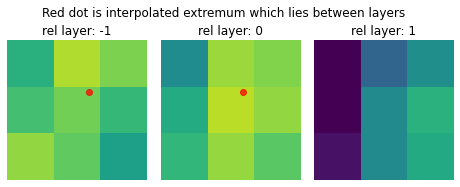

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3), gridspec_kw={'wspace':0.1, 'hspace':0}, squeeze=True)

success, interpol_coord, interpol_val = keypoints_lib.interpolate(extremum, dog_octave, derivs, second_derivs)
offset = interpol_coord - extremum

for i in range(3):
    axs[i].axis('off')
    axs[i].imshow(patch[i], vmin=0, vmax=0.0017)
    axs[i].title.set_text(f'rel layer: {i - 1}')

offset_layer = 0 if offset[0] < 0 else 2

axs[1].scatter(1 + offset[2], 1 + offset[1], c='r', alpha=1 - abs(offset[0]))
axs[offset_layer].scatter(1 + offset[2], 1 + offset[1], c='r', alpha=1-abs(offset[0]))

plt.suptitle('Red dot is interpolated extremum which lies between layers')
plt.show()

## Check if Keypoint Passes Checks

In [5]:
if abs(interpol_val) > const.magnitude_thresh:
    s, y, x = interpol_coord.round().astype(int)
    if pass_edge_test(second_derivs[:, s, y, x]):
        print('Keypoint is valid')
    else: 
        print('Fails edge test')
else: 
    print('Fails magnitude test')

Fails magnitude test


## Check percentage of valid keypoint

In [6]:
valid = 0 
invalid = 0 

for extremum_coord in extrema.T:
    passed = False
    if abs(dog_octave[tuple(extremum_coord)]) > const.coarse_magnitude_thresh:
        success, extremum_coord, extremum_val = keypoints_lib.interpolate(extremum_coord, dog_octave, derivs, second_derivs)
        if success and abs(extremum_val) > const.magnitude_thresh:
            s, y, x = extremum_coord.round().astype(int)
            if keypoints_lib.pass_edge_test(second_derivs[:, s, y, x]):
                valid += 1
                passed = True
    if passed == False: 
        invalid += 1
        
print(f'Pecentage of valid keypoints: {valid / (valid + invalid) * 100:.2f}%')

Pecentage of valid keypoints: 38.78%
